In [11]:
from transformers import (
    VisionEncoderDecoderModel, 
    ViTFeatureExtractor, 
    PreTrainedTokenizerFast,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator,
)
import torch
import numpy as np
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
import json
from sklearn.model_selection import train_test_split
from datasets import load_metric
from nltk.translate.bleu_score import corpus_bleu

In [2]:
encoder_model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_model_name_or_path)
model = VisionEncoderDecoderModel.from_pretrained('./finetuned/checkpoint-4500')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out

In [5]:
decoder_model_name_or_path = "skt/kogpt2-base-v2"
tokenizer = PreTrainedTokenizerFast.from_pretrained(decoder_model_name_or_path, bos_token='<s>', 
                                                    eos_token='</s>', unk_token='<unk>',pad_token='<pad>', mask_token='<mask>')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [6]:
import json

with open('./data/MSCOCO_train_val_Korean.json', 'r') as f:
    coco = json.load(f)

In [7]:
img_path = []
total_caption_lst = []
data_path = './data/'
for i in range(len(coco)):
    # 캡션 5개 미만이면 추가하지 않음
    if len(coco[i]['caption_ko']) < 5:
        continue
    # img path 추가
    img_path.append(data_path + coco[i]['file_path'])

    # img path와 매칭되는 caption 5개 추가
    caption_lst = []
    for j in range(5):
        caption_lst.append(coco[i]['caption_ko'][j])
    total_caption_lst.append(caption_lst)

In [9]:
import pandas as pd

coco_df = pd.DataFrame(data={
    'labels': total_caption_lst,
    'img_paths': img_path
})

In [24]:
coco_data = coco_df
train_df, val_df = train_test_split(coco_data, test_size=0.2, random_state=42)

In [29]:
val_df = val_df.reset_index()

In [32]:
img, label = val_df['img_paths'], val_df['labels']

In [63]:
def gen_text(index):
    image = Image.open(img[index]).convert("RGB")
    image_tensor = np.array(image)
    pixel_values = feature_extractor(image_tensor, return_tensors="pt").pixel_values
    image.show()

    generated_ids = model.generate(pixel_values.to(device),num_beams=5)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    #print(generated_text)

    return generated_text

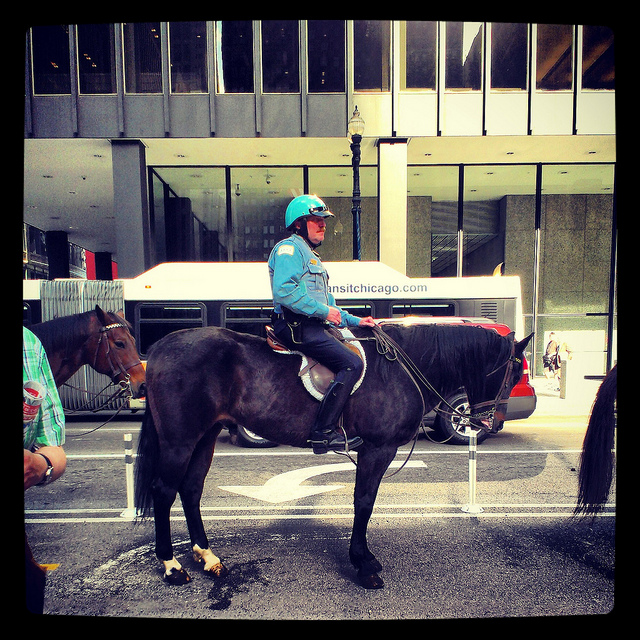

['경찰관이 말을 타고 있다.']
['검은 말 등에 탄 경찰', '공공 도로 위의 말 위에 앉아 있는 말 경찰', '한 사람이 거리에서 말을 타고 있다.', '검은 말 위에 파란 재킷과 헬멧을 쓴 남자', '말을 탄 경찰이 건물 건너 편에 서 있다.']


In [90]:
index = 66
print(gen_text(index))
print(label[index])

In [ ]:
'''
벽돌 건물 앞에 있는 표지판.
나는 그 앞에서 걸음을 멈추고 지도를 펼친다.
표지가 없어져도 길의 끝은 항상 보인다.
그곳에도 길이 있겠지.
그럼 그곳에 나의 발자국이 남겠지.
한걸음 두 걸음 지도 위를 걸어다니다 보면 내가 가본 적도 없는 어느 골목길, 누군가의 무덤이 있던 자리로.
'''

In [ ]:
'''
벽돌 건물 앞에 있는 표지판.
문득, 문 닫힌 대문에 오래도록 눈이 머물렀다
새로운 계절에 어울리는 집이라 이름 지었을 것이고
또한, 한 번도 버려져 본 적 없는 낡은 이층집이
세상 모든 곳에서 온기로 전해질 수 있도록,
모든 것을 하얗게
'''